In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import warnings

In [15]:
# Load your dataset
merge_df_scaled = pd.read_csv('../raw_data/merge_df_scaled.csv')
merge_df_scaled['date'] = pd.to_datetime(merge_df_scaled['date'])
merge_df_scaled.set_index('date', inplace=True)

merge_df_scaled.head()
# 382600 rows × 64 columns

,id,item_id,dept_id,store_id,state_id,sales,wday,month,year,snap_CA,...,event_name_1_missing,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_name_2_missing,wday_sin,wday_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,CA_1,CA,12,1,1,0.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.781831,0.62349,0.5,0.866025
2011-01-29,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,CA_1,CA,4,1,1,0.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.781831,0.62349,0.5,0.866025
2011-01-29,HOBBIES_1_016_CA_1_validation,HOBBIES_1_016,HOBBIES_1,CA_1,CA,5,1,1,0.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.781831,0.62349,0.5,0.866025
2011-01-29,HOBBIES_1_019_CA_1_validation,HOBBIES_1_019,HOBBIES_1,CA_1,CA,0,1,1,0.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.781831,0.62349,0.5,0.866025
2011-01-29,HOBBIES_1_032_CA_1_validation,HOBBIES_1_032,HOBBIES_1,CA_1,CA,9,1,1,0.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.781831,0.62349,0.5,0.866025


<Axes: xlabel='date'>

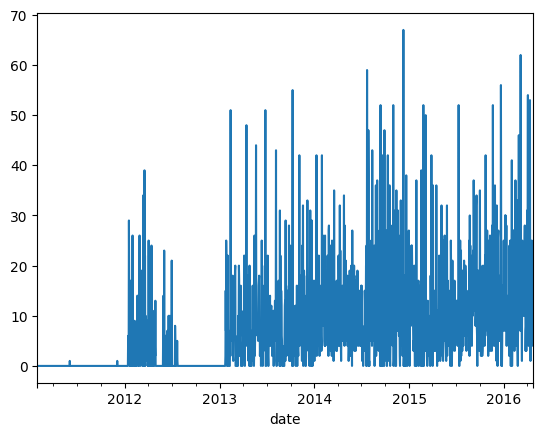

In [3]:
merge_df_scaled[merge_df_scaled['id'] == 'HOBBIES_1_048_CA_1_validation'].sales.plot()

In [4]:
merge_df_scaled[merge_df_scaled['id'] == 'HOBBIES_1_048_CA_1_validation'].sales.mean()

7.248823836905384

# 1.Auto_ARIMA with mae

In [5]:
from pmdarima import auto_arima

# Initialize time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Dictionary to store MAE results for each unique time-series identified by id
product_results = {}

# Iterate over each unique product series identified by id
for id in merge_df_scaled['id'].unique()[:10]:
    print(f"Analyzing product: {id}")
    product_data = merge_df_scaled[merge_df_scaled['id'] == id]

    # Assuming 'sales' is the column you are predicting
    y = product_data['sales']

    # Results list for the current product time-series
    results = []

    # Time-series split and model fitting
    for train_index, test_index in tscv.split(y):
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit ARIMA model on the training data using auto_arima to find the best (p, d, q)
        model = auto_arima(y_train, start_p=0, start_q=0, max_p=5, max_q=5, d=1,
                           seasonal=True, trace=False, error_action='ignore', 
                           suppress_warnings=True, stepwise=True)

        # Predict on the test data
        predictions = model.predict(n_periods=len(y_test))

        # Calculate and store the error metric for the current fold
        mae = mean_absolute_error(y_test, predictions)
        results.append(mae)

    # Store the average MAE for the current product time-series
    product_results[id] = np.mean(results)
    print(f'Mean Absolute Error for {id}: {product_results[id]}')

# Create a DataFrame to store the results
results_df_arima = pd.DataFrame(product_results.items(), columns=['id', 'ARIMA_MAE'])

# Set the 'id' column as the index
results_df_arima.set_index('id', inplace=True)

# Print or save the results DataFrame
print(results_df_arima )


Analyzing product: HOBBIES_1_008_CA_1_validation
Mean Absolute Error for HOBBIES_1_008_CA_1_validation: 6.531439912307252
Analyzing product: HOBBIES_1_015_CA_1_validation
Mean Absolute Error for HOBBIES_1_015_CA_1_validation: 5.591126104294296
Analyzing product: HOBBIES_1_016_CA_1_validation
Mean Absolute Error for HOBBIES_1_016_CA_1_validation: 4.480104928122013
Analyzing product: HOBBIES_1_019_CA_1_validation


/home/sljaoudli/.pyenv/versions/3.10.6/envs/walmart/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Mean Absolute Error for HOBBIES_1_019_CA_1_validation: 5.017304607676345
Analyzing product: HOBBIES_1_032_CA_1_validation
Mean Absolute Error for HOBBIES_1_032_CA_1_validation: 5.426358393731762
Analyzing product: HOBBIES_1_048_CA_1_validation
Mean Absolute Error for HOBBIES_1_048_CA_1_validation: 6.173674513470148
Analyzing product: HOBBIES_1_067_CA_1_validation
Mean Absolute Error for HOBBIES_1_067_CA_1_validation: 5.050133920887946
Analyzing product: HOBBIES_1_169_CA_1_validation
Mean Absolute Error for HOBBIES_1_169_CA_1_validation: 5.745131589612624
Analyzing product: HOBBIES_1_178_CA_1_validation
Mean Absolute Error for HOBBIES_1_178_CA_1_validation: 7.5239279847934615
Analyzing product: HOBBIES_1_189_CA_1_validation
Mean Absolute Error for HOBBIES_1_189_CA_1_validation: 5.307591984530755
                               ARIMA_MAE
id                                      
HOBBIES_1_008_CA_1_validation   6.531440
HOBBIES_1_015_CA_1_validation   5.591126
HOBBIES_1_016_CA_1_validation 

In [6]:
results_df_arima 

,ARIMA_MAE
id,
HOBBIES_1_008_CA_1_validation,6.531440
HOBBIES_1_015_CA_1_validation,5.591126
HOBBIES_1_016_CA_1_validation,4.480105
HOBBIES_1_019_CA_1_validation,5.017305
HOBBIES_1_032_CA_1_validation,5.426358
HOBBIES_1_048_CA_1_validation,6.173675
HOBBIES_1_067_CA_1_validation,5.050134
HOBBIES_1_169_CA_1_validation,5.745132
HOBBIES_1_178_CA_1_validation,7.523928


# 2.Holt-Winters Exponential Smoothing model with mae 

In [7]:
import optuna

# Define the objective function
def objective(trial, y_train, tscv):
    trend = trial.suggest_categorical('trend', ['add'])
    seasonal = trial.suggest_categorical('seasonal', [None, 'add'])
    seasonal_periods = trial.suggest_categorical('seasonal_periods', [None, 4, 7, 12])
    
    product_results = []
    for train_index, test_index in tscv.split(y_train):
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Fit Holt-Winters model on the training data
        model = ExponentialSmoothing(y_train_fold, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods,freq='D')
        fitted_model = model.fit(optimized=True)

        # Predict on the test data
        predictions = fitted_model.forecast(steps=len(y_test_fold))

        # Calculate and store the error metric
        mae = mean_absolute_error(y_test_fold, predictions)
        product_results.append(mae)

    # Average MAE for this product
    average_mae = np.mean(product_results)
    return average_mae

# Create a dictionary to store results
results_dict = {}

# Iterate over each unique product ID
for id in merge_df_scaled['id'].unique()[:10]:

    # Create a study object
    study = optuna.create_study(direction='minimize')
    
    print(f"Optimizing hyperparameters for product: {id}")
    product_data = merge_df_scaled[merge_df_scaled['id'] == id]
    y_train = product_data['sales']
    
    # Initialize time series cross-validator
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Run the optimization process for the current product
    study.optimize(lambda trial: objective(trial, y_train, tscv), n_trials=10)

    # Get the best hyperparameters and the corresponding best MAE
    best_params = study.best_params
    best_mae = study.best_value
    
    # Store the results in the dictionary
    results_dict[id] = {'ExpSmoothing_params': best_params, 'ExpSmoothing_MAE': best_mae}

# Print the results dictionary
print(results_dict)



/home/sljaoudli/.pyenv/versions/3.10.6/envs/walmart/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-05-09 10:55:12,029] A new study created in memory with name: no-name-1aa249a5-59f3-4f91-b009-abf071e542fe


Optimizing hyperparameters for product: HOBBIES_1_008_CA_1_validation


[I 2024-05-09 10:55:12,890] Trial 0 finished with value: 7.6103422586045 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 0 with value: 7.6103422586045.
[I 2024-05-09 10:55:13,730] Trial 1 finished with value: 7.66532590138519 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12}. Best is trial 0 with value: 7.6103422586045.
[I 2024-05-09 10:55:14,537] Trial 2 finished with value: 7.66532590138519 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12}. Best is trial 0 with value: 7.6103422586045.
[I 2024-05-09 10:55:14,704] Trial 3 finished with value: 7.614596442667808 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 7}. Best is trial 0 with value: 7.6103422586045.
[I 2024-05-09 10:55:15,514] Trial 4 finished with value: 7.6103422586045 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': None}. Best is trial 0 with value: 7.6103422586045.
[I 2024-05-09 10:55:16

Optimizing hyperparameters for product: HOBBIES_1_015_CA_1_validation


[I 2024-05-09 10:55:18,776] Trial 1 finished with value: 6.258853759851106 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': None}. Best is trial 1 with value: 6.258853759851106.
[I 2024-05-09 10:55:19,570] Trial 2 finished with value: 6.259857304075206 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 4}. Best is trial 1 with value: 6.258853759851106.
[I 2024-05-09 10:55:19,758] Trial 3 finished with value: 6.3666854973349825 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 12}. Best is trial 1 with value: 6.258853759851106.
[I 2024-05-09 10:55:19,965] Trial 4 finished with value: 6.3666854973349825 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 12}. Best is trial 1 with value: 6.258853759851106.
[I 2024-05-09 10:55:20,777] Trial 5 finished with value: 6.258853759851106 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 1 with value: 6.258853759851106.
[I 20

Optimizing hyperparameters for product: HOBBIES_1_016_CA_1_validation


[I 2024-05-09 10:55:23,111] Trial 1 finished with value: 4.3467783196448355 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 0 with value: 4.3467783196448355.
[I 2024-05-09 10:55:23,911] Trial 2 finished with value: 4.354825087112998 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': None}. Best is trial 0 with value: 4.3467783196448355.
[I 2024-05-09 10:55:24,745] Trial 3 finished with value: 4.354825087112998 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 0 with value: 4.3467783196448355.
[I 2024-05-09 10:55:24,929] Trial 4 finished with value: 4.3467783196448355 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 0 with value: 4.3467783196448355.
[I 2024-05-09 10:55:25,109] Trial 5 finished with value: 4.3467783196448355 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 0 with value: 4.3467783196448355.
[I

Optimizing hyperparameters for product: HOBBIES_1_019_CA_1_validation


[I 2024-05-09 10:55:27,891] Trial 0 finished with value: 5.024294512764064 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 0 with value: 5.024294512764064.
[I 2024-05-09 10:55:28,041] Trial 1 finished with value: 5.019810993274403 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': None}. Best is trial 1 with value: 5.019810993274403.
[I 2024-05-09 10:55:28,195] Trial 2 finished with value: 5.019810993274403 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 1 with value: 5.019810993274403.
[I 2024-05-09 10:55:28,969] Trial 3 finished with value: 5.024294512764064 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': None}. Best is trial 1 with value: 5.019810993274403.
[I 2024-05-09 10:55:29,693] Trial 4 finished with value: 5.033824515784955 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 4}. Best is trial 1 with value: 5.019810993274403.
[I 202

Optimizing hyperparameters for product: HOBBIES_1_032_CA_1_validation


[I 2024-05-09 10:55:33,991] Trial 1 finished with value: 5.840780941861496 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12}. Best is trial 0 with value: 5.7998832274835275.
[I 2024-05-09 10:55:34,149] Trial 2 finished with value: 5.7998832274835275 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 12}. Best is trial 0 with value: 5.7998832274835275.
[I 2024-05-09 10:55:34,930] Trial 3 finished with value: 5.8636055102647155 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': None}. Best is trial 0 with value: 5.7998832274835275.
[I 2024-05-09 10:55:35,699] Trial 4 finished with value: 5.954081581145212 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 4}. Best is trial 0 with value: 5.7998832274835275.
[I 2024-05-09 10:55:36,479] Trial 5 finished with value: 5.8636055102647155 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 0 with value: 5.7998832274835275

Optimizing hyperparameters for product: HOBBIES_1_048_CA_1_validation


[I 2024-05-09 10:55:39,408] Trial 1 finished with value: 6.3588789999527835 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12}. Best is trial 0 with value: 6.325378241099327.
[I 2024-05-09 10:55:40,179] Trial 2 finished with value: 6.340359349584359 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 0 with value: 6.325378241099327.
[I 2024-05-09 10:55:40,939] Trial 3 finished with value: 6.340359349584359 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 0 with value: 6.325378241099327.
[I 2024-05-09 10:55:41,709] Trial 4 finished with value: 6.340359349584359 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': None}. Best is trial 0 with value: 6.325378241099327.
[I 2024-05-09 10:55:41,862] Trial 5 finished with value: 6.325378241099327 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 0 with value: 6.325378241099327.
[I 202

Optimizing hyperparameters for product: HOBBIES_1_067_CA_1_validation


[I 2024-05-09 10:55:44,660] Trial 1 finished with value: 6.1618137132273425 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 1 with value: 6.1618137132273425.
[I 2024-05-09 10:55:45,467] Trial 2 finished with value: 6.1618137132273425 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': None}. Best is trial 1 with value: 6.1618137132273425.
[I 2024-05-09 10:55:46,298] Trial 3 finished with value: 6.1618137132273425 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 1 with value: 6.1618137132273425.
[I 2024-05-09 10:55:47,105] Trial 4 finished with value: 6.1618137132273425 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 1 with value: 6.1618137132273425.
[I 2024-05-09 10:55:47,282] Trial 5 finished with value: 7.397780734599904 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 12}. Best is trial 1 with value: 6.1618137132273425

Optimizing hyperparameters for product: HOBBIES_1_169_CA_1_validation


[I 2024-05-09 10:55:49,464] Trial 0 finished with value: 6.2148961645602565 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12}. Best is trial 0 with value: 6.2148961645602565.
[I 2024-05-09 10:55:50,243] Trial 1 finished with value: 5.2873166243523935 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': None}. Best is trial 1 with value: 5.2873166243523935.
[I 2024-05-09 10:55:50,442] Trial 2 finished with value: 5.085608253730564 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': None}. Best is trial 2 with value: 5.085608253730564.
[I 2024-05-09 10:55:50,622] Trial 3 finished with value: 5.085608253730564 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 2 with value: 5.085608253730564.
[I 2024-05-09 10:55:50,816] Trial 4 finished with value: 5.085608253730564 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 2 with value: 5.085608253730564.
[I

Optimizing hyperparameters for product: HOBBIES_1_178_CA_1_validation


[I 2024-05-09 10:55:53,810] Trial 0 finished with value: 10.027016340517497 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 4}. Best is trial 0 with value: 10.027016340517497.
[I 2024-05-09 10:55:54,567] Trial 1 finished with value: 10.027016340517497 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 4}. Best is trial 0 with value: 10.027016340517497.
[I 2024-05-09 10:55:54,745] Trial 2 finished with value: 10.378998976173628 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': None}. Best is trial 0 with value: 10.027016340517497.
[I 2024-05-09 10:55:54,908] Trial 3 finished with value: 10.378998976173628 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 0 with value: 10.027016340517497.
[I 2024-05-09 10:55:55,705] Trial 4 finished with value: 9.991154041893598 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}. Best is trial 4 with value: 9.991154041893598.
[

Optimizing hyperparameters for product: HOBBIES_1_189_CA_1_validation


[I 2024-05-09 10:55:59,444] Trial 1 finished with value: 5.564773209655063 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 12}. Best is trial 0 with value: 5.564773209655063.
[I 2024-05-09 10:55:59,602] Trial 2 finished with value: 5.564773209655063 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 0 with value: 5.564773209655063.
[I 2024-05-09 10:55:59,762] Trial 3 finished with value: 5.564773209655063 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 0 with value: 5.564773209655063.
[I 2024-05-09 10:56:00,564] Trial 4 finished with value: 5.693679100171769 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12}. Best is trial 0 with value: 5.564773209655063.
[I 2024-05-09 10:56:00,724] Trial 5 finished with value: 5.564773209655063 and parameters: {'trend': 'add', 'seasonal': None, 'seasonal_periods': 4}. Best is trial 0 with value: 5.564773209655063.
[I 2024-05-0

{'HOBBIES_1_008_CA_1_validation': {'ExpSmoothing_params': {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 7}, 'ExpSmoothing_MAE': 7.6103422586045}, 'HOBBIES_1_015_CA_1_validation': {'ExpSmoothing_params': {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': None}, 'ExpSmoothing_MAE': 6.258853759851106}, 'HOBBIES_1_016_CA_1_validation': {'ExpSmoothing_params': {'trend': 'add', 'seasonal': None, 'seasonal_periods': 7}, 'ExpSmoothing_MAE': 4.3467783196448355}, 'HOBBIES_1_019_CA_1_validation': {'ExpSmoothing_params': {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12}, 'ExpSmoothing_MAE': 5.017658523500397}, 'HOBBIES_1_032_CA_1_validation': {'ExpSmoothing_params': {'trend': 'add', 'seasonal': None, 'seasonal_periods': None}, 'ExpSmoothing_MAE': 5.7998832274835275}, 'HOBBIES_1_048_CA_1_validation': {'ExpSmoothing_params': {'trend': 'add', 'seasonal': None, 'seasonal_periods': 12}, 'ExpSmoothing_MAE': 6.325378241099327}, 'HOBBIES_1_067_CA_1_validation': {'ExpSmoothing_para

In [8]:
# Convert the results dictionary to a DataFrame
results_df_exp = pd.DataFrame(results_dict).T.reset_index()
results_df_exp.columns = ['id', 'ExpSmoothing_params', 'ExpSmoothing_MAE']

# Set the 'Product ID' column as the index
results_df_exp.set_index('id', inplace=True)
results_df_exp

,ExpSmoothing_params,ExpSmoothing_MAE
id,,
HOBBIES_1_008_CA_1_validation,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",7.610342
HOBBIES_1_015_CA_1_validation,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",6.258854
HOBBIES_1_016_CA_1_validation,"{'trend': 'add', 'seasonal': None, 'seasonal_p...",4.346778
HOBBIES_1_019_CA_1_validation,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",5.017659
HOBBIES_1_032_CA_1_validation,"{'trend': 'add', 'seasonal': None, 'seasonal_p...",5.799883
HOBBIES_1_048_CA_1_validation,"{'trend': 'add', 'seasonal': None, 'seasonal_p...",6.325378
HOBBIES_1_067_CA_1_validation,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",6.161814
HOBBIES_1_169_CA_1_validation,"{'trend': 'add', 'seasonal': None, 'seasonal_p...",5.085608
HOBBIES_1_178_CA_1_validation,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",9.991154


In [9]:
# Merge the two DataFrames based on the product ID
comparison_df = pd.merge(results_df_arima, results_df_exp, left_index=True, right_index=True, suffixes=('_arima', '_exp'))
comparison_df['Best MAE'] = comparison_df[['ARIMA_MAE', 'ExpSmoothing_MAE']].min(axis=1)
comparison_df['Best Method'] = comparison_df.apply(lambda row: 'ARIMA' if row['Best MAE'] == row['ARIMA_MAE'] else 'Exponential Smoothing', axis=1)

comparison_df


,ARIMA_MAE,ExpSmoothing_params,ExpSmoothing_MAE,Best MAE,Best Method
id,,,,,
HOBBIES_1_008_CA_1_validation,6.531440,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",7.610342,6.53144,ARIMA
HOBBIES_1_015_CA_1_validation,5.591126,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",6.258854,5.591126,ARIMA
HOBBIES_1_016_CA_1_validation,4.480105,"{'trend': 'add', 'seasonal': None, 'seasonal_p...",4.346778,4.346778,Exponential Smoothing
HOBBIES_1_019_CA_1_validation,5.017305,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",5.017659,5.017305,ARIMA
HOBBIES_1_032_CA_1_validation,5.426358,"{'trend': 'add', 'seasonal': None, 'seasonal_p...",5.799883,5.426358,ARIMA
HOBBIES_1_048_CA_1_validation,6.173675,"{'trend': 'add', 'seasonal': None, 'seasonal_p...",6.325378,6.173675,ARIMA
HOBBIES_1_067_CA_1_validation,5.050134,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",6.161814,5.050134,ARIMA
HOBBIES_1_169_CA_1_validation,5.745132,"{'trend': 'add', 'seasonal': None, 'seasonal_p...",5.085608,5.085608,Exponential Smoothing
HOBBIES_1_178_CA_1_validation,7.523928,"{'trend': 'add', 'seasonal': 'add', 'seasonal_...",9.991154,7.523928,ARIMA
